# Predict `Subject Age`

In [1]:
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import time
from pathlib import Path

In [4]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
phenotype = 'Subject Age'

In [7]:
#load data
aging_dir = Path('/home/ubuntu/a/aging/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

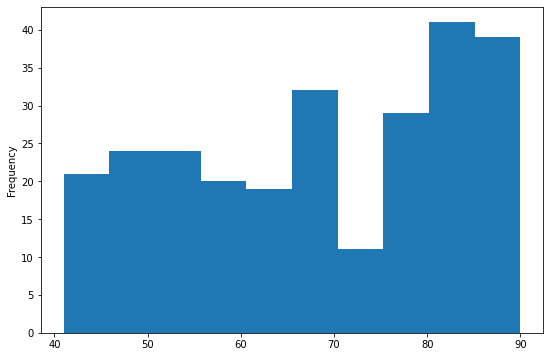

In [8]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist()

In [9]:
##### Step 3: split train, validation and test######
x = []
y = []
for i, row in samples.iterrows():
    x.append(cyto_data[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
age_min = min(y_raw)
age_max = max(y_raw)
age_range = age_max - age_min
y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

In [109]:
model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(4, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(8, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(8, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
])
model.compile(loss='huber',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 5000, 1, 4)        112       
_________________________________________________________________
batch_normalization_41 (Batc (None, 5000, 1, 4)        16        
_________________________________________________________________
activation_41 (Activation)   (None, 5000, 1, 4)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5000, 1, 8)        40        
_________________________________________________________________
batch_normalization_42 (Batc (None, 5000, 1, 8)        32        
_________________________________________________________________
activation_42 (Activation)   (None, 5000, 1, 8)        0         
_________________________________________________________________
average_pooling2d_14 (Averag (None, 1, 1, 8)         

In [110]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=10,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/200
20/20 [==============================] - 1s 19ms/step - loss: 0.4749 - mean_absolute_error: 0.8987 - val_loss: 0.2670 - val_mean_absolute_error: 0.6722
Epoch 2/200
20/20 [==============================] - 0s 8ms/step - loss: 0.3521 - mean_absolute_error: 0.7553 - val_loss: 0.2500 - val_mean_absolute_error: 0.6467
Epoch 3/200
20/20 [==============================] - 0s 7ms/step - loss: 0.2702 - mean_absolute_error: 0.6420 - val_loss: 0.2342 - val_mean_absolute_error: 0.6223
Epoch 4/200
20/20 [==============================] - 0s 7ms/step - loss: 0.2025 - mean_absolute_error: 0.5343 - val_loss: 0.2161 - val_mean_absolute_error: 0.5925
Epoch 5/200
20/20 [==============================] - 0s 7ms/step - loss: 0.1569 - mean_absolute_error: 0.4561 - val_loss: 0.1949 - val_mean_absolute_error: 0.5579
Epoch 6/200
20/20 [==============================] - 0s 7ms/step - loss: 0.1192 - mean_absolute_error: 0.3968 - val_loss: 0.1766 - val_mean_absolute_error: 0.5283
Epoch 7/200
20/20 [==

In [111]:
rt

27.559773921966553

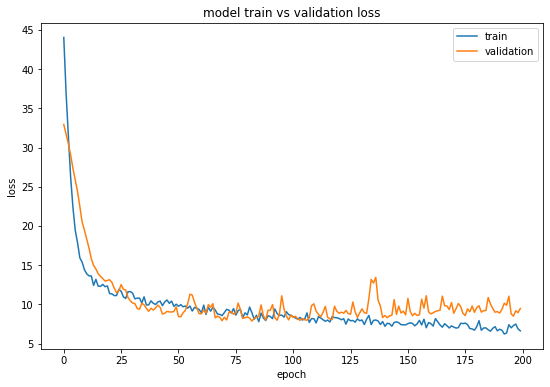

In [112]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [113]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])

In [114]:
errors = age_range * (pd.Series(y_test)-pd.Series(y_scores))
errors.describe()

count    65.000000
mean      3.116616
std      10.184861
min     -22.242418
25%      -1.544630
50%       3.029677
75%      10.100791
max      28.020656
dtype: float64

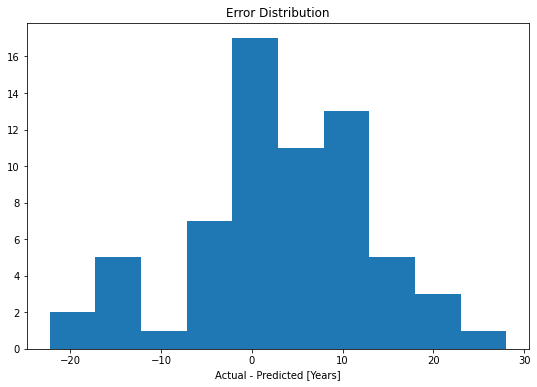

In [115]:
plt.hist(errors)
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

[ 0.48108919 33.55840306]


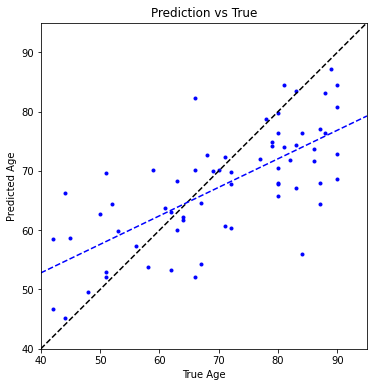

In [116]:
age_true = y_test*age_range + age_min
age_pred = y_scores*age_range + age_min
plt.plot(age_true, age_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(age_true, age_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()